In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
def plot_metrics_table(metrics_df):
    # Recompute metrics based on the clarified definitions
    metrics_df['lora_id'] = metrics_df['lora_id'].astype('str')
    metrics_df['itl'] = (metrics_df['last_token_time'] - metrics_df['first_scheduled_time']) / metrics_df['output_num_tokens']
    metrics_df['ttft'] = metrics_df['first_scheduled_time'] - metrics_df['arrival_time']
    metrics_df['total_latency'] = (metrics_df['finished_time'] - metrics_df['arrival_time'])

    # Create multi-level index for the metrics we want to track
    metrics = {
        'total_latency': 'E2E',
        'itl': 'ITL',
        'ttft': 'TTFT'
    }
    
    # Group by policy and s_max (num_iters_before_lora_reschedule)
    grouped = metrics_df.groupby(['lora_policy', 'num_iters_before_lora_reschedule', 'max_loras'])
    
    # Calculate statistics across all LoRA IDs for each policy/s_max combination
    stats = grouped.agg({
        metric: ['median', 'mean', 'max'] for metric in metrics.keys()
    }).reset_index()
    
    # Filter for max_loras = 4
    stats = stats[stats['max_loras'] == 4]
    
    # Rename columns for better readability
    new_columns = []
    for metric_name, display_name in metrics.items():
        for stat in ['median', 'mean', 'max']:
            new_columns.append(f'{display_name} {stat}')
    
    # Prepare the rows with policy and s_max information
    rows = []
    for idx in stats.index:
        row = stats.loc[idx]
        policy = 'Naive' if row['lora_policy'].iloc[0] == 'LoraPolicy.NAIVE' else 'Round Robin'
        s_max = row['num_iters_before_lora_reschedule'].iloc[0]
        policy_name = f'{policy} (s_max={s_max})' if policy == 'Round Robin' else policy
        
        # Extract the statistics in the desired order
        stats_values = []
        for metric in metrics.keys():
            stats_values.extend([
                row[(metric, 'median')],
                row[(metric, 'mean')],
                row[(metric, 'max')]
            ])
        
        rows.append([policy_name] + stats_values)
    
    # Create DataFrame with the formatted data
    results_df = pd.DataFrame(
        rows,
        columns=['Policy'] + new_columns
    )
    
    # Sort the DataFrame to put Naive first, then Round Robin with increasing s_max
    results_df = results_df.sort_values(
        by='Policy',
        key=lambda x: [1 if 'Naive' in v else 2 for v in x]
    )
    
    # Format numeric values to 3 decimal places
    for col in new_columns:
        results_df[col] = results_df[col].round(3)
    
    return results_df

df = plot_metrics_table(pd.read_csv('../out/metrics_new.csv'))
df = df.iloc[[2, 6, 7, 8, 9, 10, 11, 12, 13]]
df.to_csv('../out/metrics_table.csv', index=False)
df

,Policy,E2E median,E2E mean,E2E max,ITL median,ITL mean,ITL max,TTFT median,TTFT mean,TTFT max
2,Naive,1.143,1.898,6.509,0.037,0.055,0.337,0.516,1.015,5.919
6,Naive,1.165,1.908,6.532,0.039,0.056,0.338,0.515,1.012,5.916
7,Round Robin (s_max=1),1.776,2.012,6.829,0.110,0.119,0.391,0.052,0.102,1.439
8,Round Robin (s_max=2),1.891,2.067,6.529,0.117,0.121,0.371,0.034,0.135,2.148
9,Round Robin (s_max=4),2.266,2.605,7.069,0.142,0.152,0.377,0.001,0.165,2.796
10,Round Robin (s_max=8),1.765,1.977,6.393,0.110,0.106,0.343,0.034,0.283,4.634
11,Round Robin (s_max=16),1.745,1.880,6.457,0.096,0.093,0.320,0.098,0.388,4.887
12,Round Robin (s_max=32),1.532,1.812,6.436,0.061,0.069,0.313,0.346,0.704,5.398
13,Round Robin (s_max=64),1.906,2.174,7.465,0.037,0.049,0.315,1.074,1.388,6.414


In [8]:
def plot_metrics(metrics_df):
    # Recompute metrics based on the clarified definitions
    metrics_df['lora_id'] = metrics_df['lora_id'].astype('str')
    metrics_df['itl'] = (metrics_df['last_token_time'] - metrics_df['first_scheduled_time']) / metrics_df['output_num_tokens']
    metrics_df['ttft'] = metrics_df['first_scheduled_time'] - metrics_df['arrival_time']
    metrics_df['total_latency'] = (metrics_df['finished_time'] - metrics_df['arrival_time'])

    # Group by LoRA policy, LoRA ID, and num_iters_before_lora_reschedule
    revised_grouped = metrics_df.groupby(
        ['lora_policy', 'lora_id', 'num_iters_before_lora_reschedule', 'max_loras']
    ).agg({
        'total_latency': ['mean', 'median', 'std', 'max'],
        'itl': ['mean', 'median', 'std', 'max'],
        'ttft': ['mean', 'median', 'std', 'max']
    }).reset_index()

    # Simplify column names
    new_cols = [
        'lora_policy', 'lora_id', 'num_iters_before_lora_reschedule', 'max_loras',
        'latency_mean', 'latency_median', 'latency_std', 'latency_max',
        'itl_mean', 'itl_median', 'itl_std', 'itl_max',
        'ttft_mean', 'ttft_median', 'ttft_std', 'ttft_max'
    ]
    revised_grouped.columns = new_cols

    # Filter for max_loras = 4
    revised_grouped = revised_grouped[revised_grouped['max_loras'] == 4]
    unique_iters = sorted(revised_grouped['num_iters_before_lora_reschedule'].unique())

    # Create separate figures for each num_iters
    for num_iters in unique_iters:
        # Create a new figure with 2x3 subplot layout
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Metrics for s_max={num_iters}', fontsize=16)

        # Filter data for the current num_iters
        subset = revised_grouped[revised_grouped['num_iters_before_lora_reschedule'] == num_iters]
        naive_subset = revised_grouped[revised_grouped['num_iters_before_lora_reschedule'] == 8]
        naive_data = naive_subset[naive_subset['lora_policy'] == 'LoraPolicy.NAIVE']
        rr_data = subset[subset['lora_policy'] == 'LoraPolicy.ROUND_ROBIN']

        # Plot metrics
        metrics = [
            ('latency', 'E2E Latency', 's'),
            ('itl', 'ITL', 's/token'),
            ('ttft', 'TTFT', 's')
        ]

        for col, (metric, title, unit) in enumerate(metrics):
            # Median metrics (row 0)
            axs[0, col].bar(naive_data['lora_id'], naive_data[f'{metric}_median'], 
                          label='NAIVE', alpha=0.7)
            axs[0, col].bar(rr_data['lora_id'], rr_data[f'{metric}_median'], 
                          label='ROUND_ROBIN', alpha=0.7)
            axs[0, col].set_title(f'Median {title}')
            axs[0, col].set_xlabel('LoRA ID')
            axs[0, col].set_ylabel(f'{title} ({unit})')

            # Max metrics (row 1)
            axs[1, col].bar(naive_data['lora_id'], naive_data[f'{metric}_max'], 
                          label='NAIVE', alpha=0.7)
            axs[1, col].bar(rr_data['lora_id'], rr_data[f'{metric}_max'], 
                          label='ROUND_ROBIN', alpha=0.7)
            axs[1, col].set_title(f'Max {title}')
            axs[1, col].set_xlabel('LoRA ID')
            axs[1, col].set_ylabel(f'{title} ({unit})')

        # Add a single legend for the entire figure
        handles, labels = axs[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5))

        plt.tight_layout()
        # Adjust layout to prevent legend overlap
        plt.subplots_adjust(right=0.92)
        plt.show()

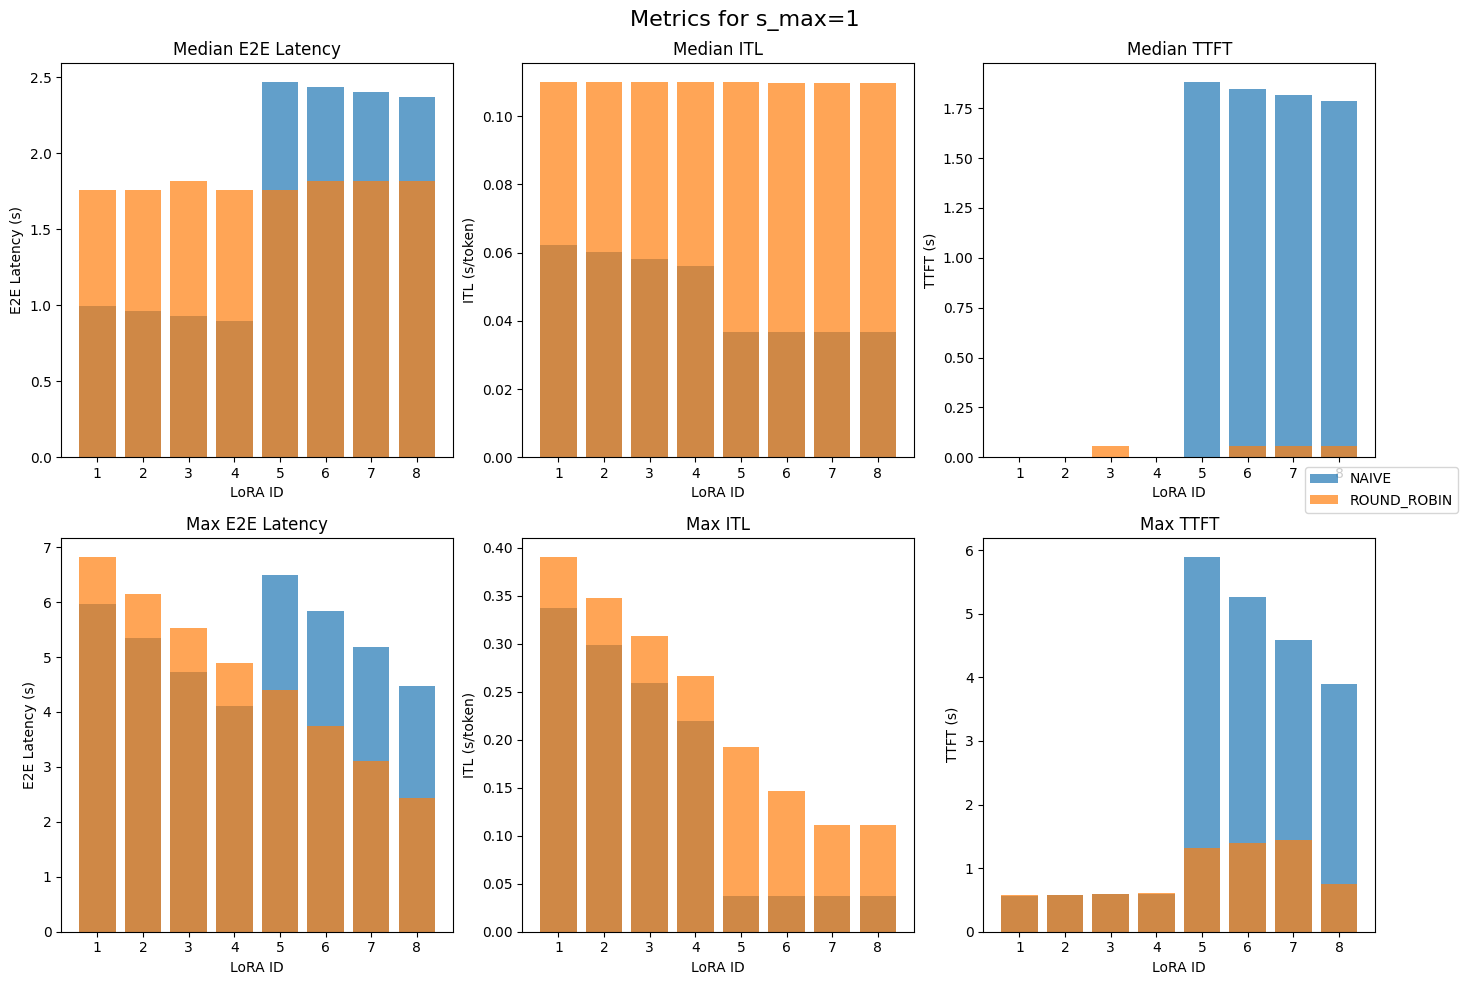

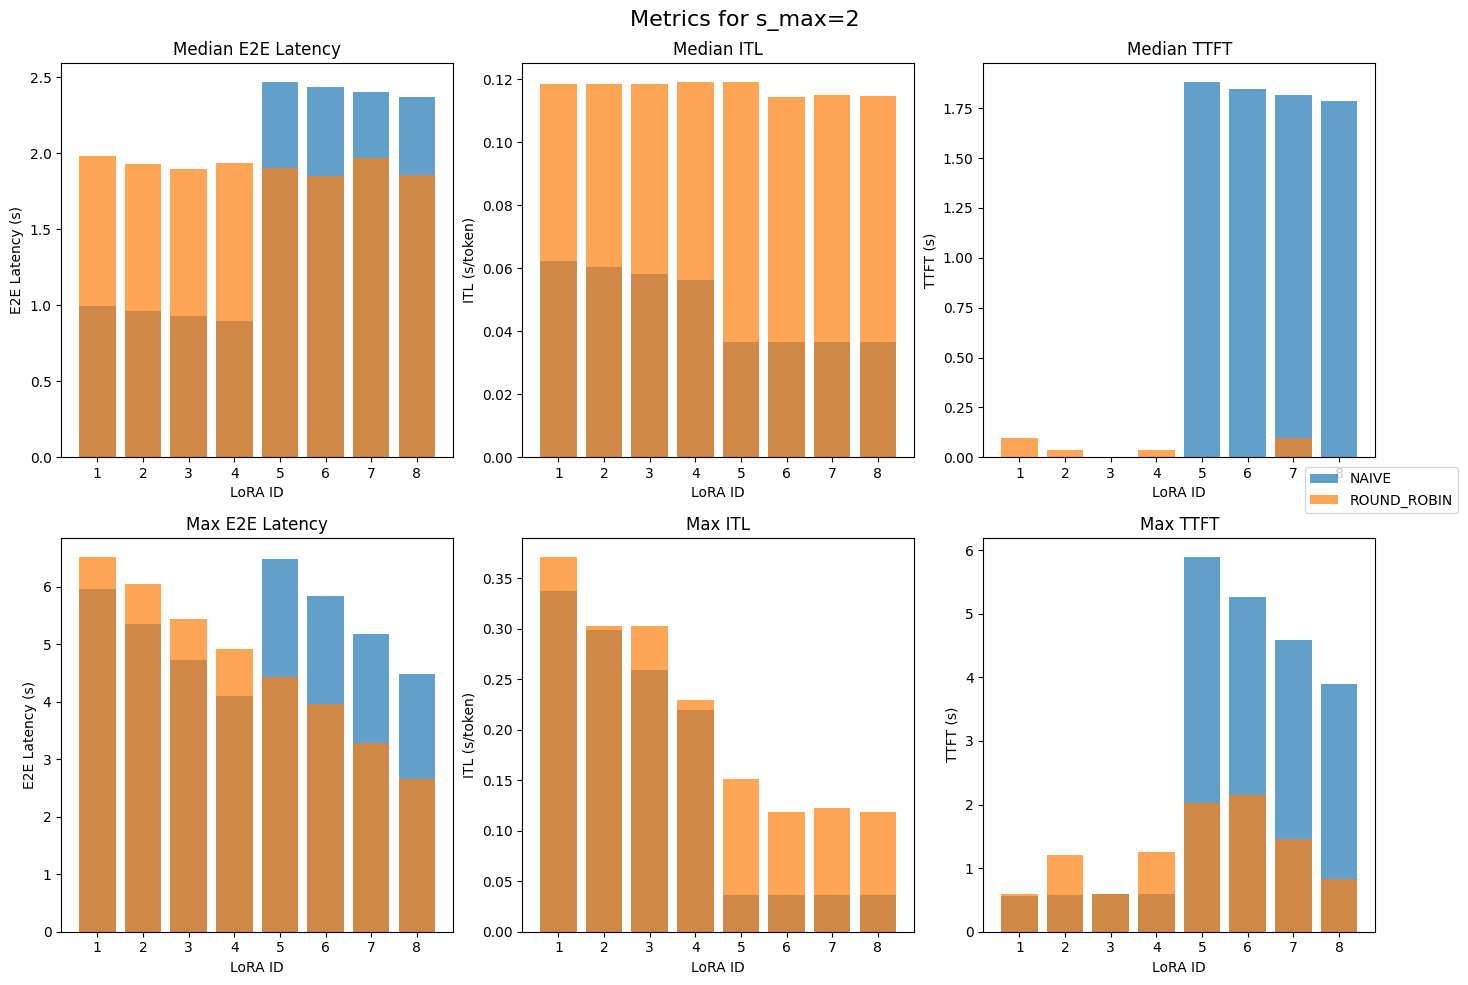

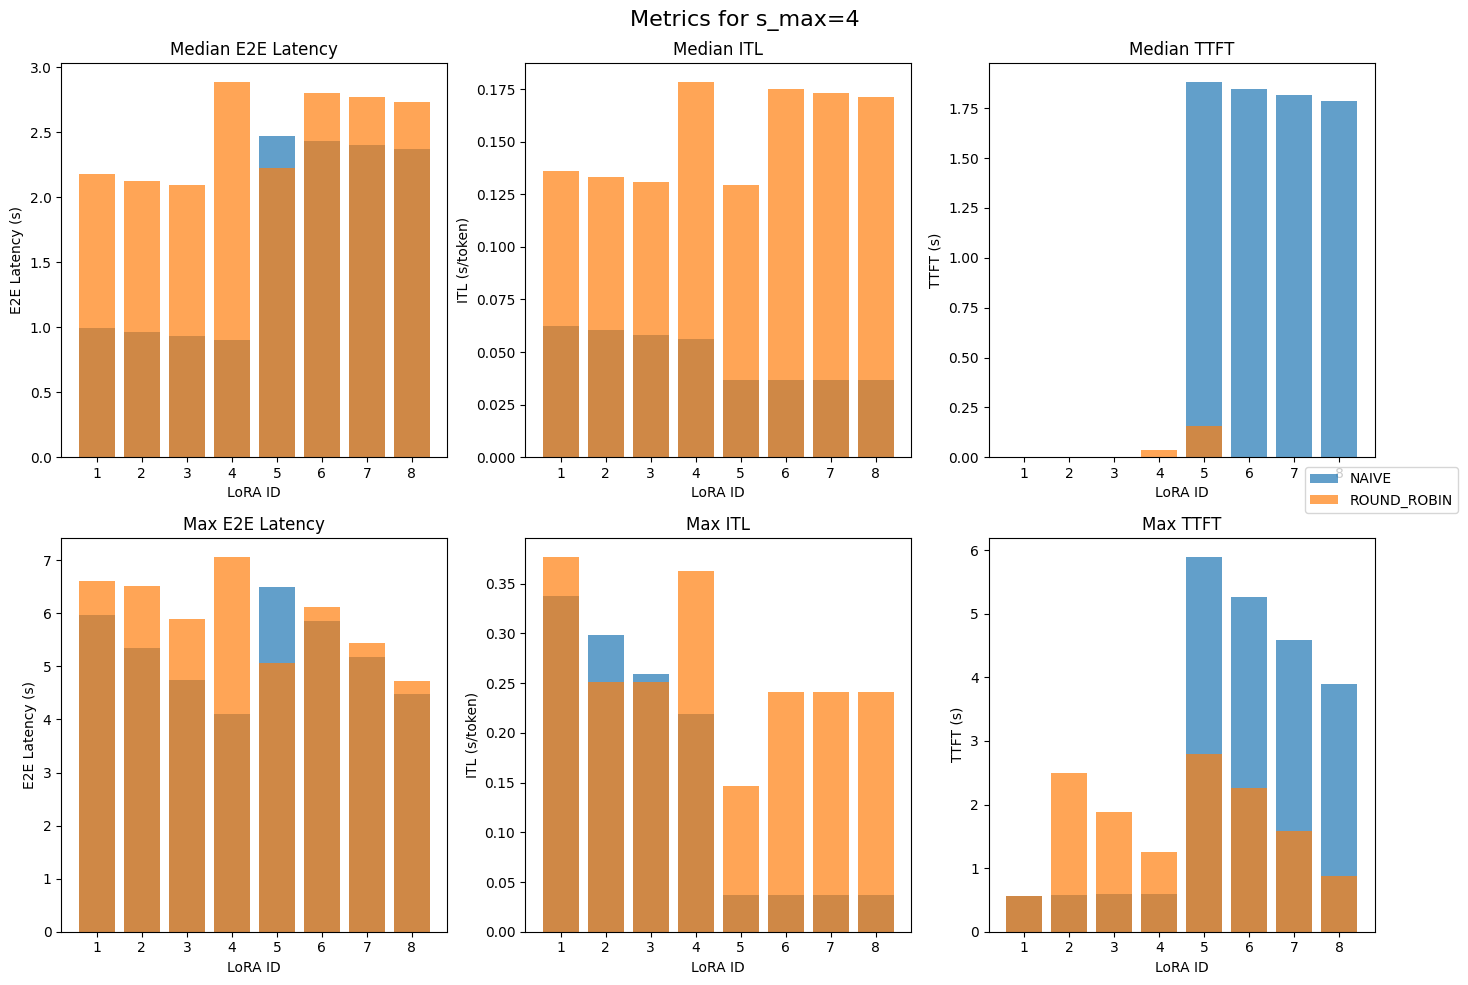

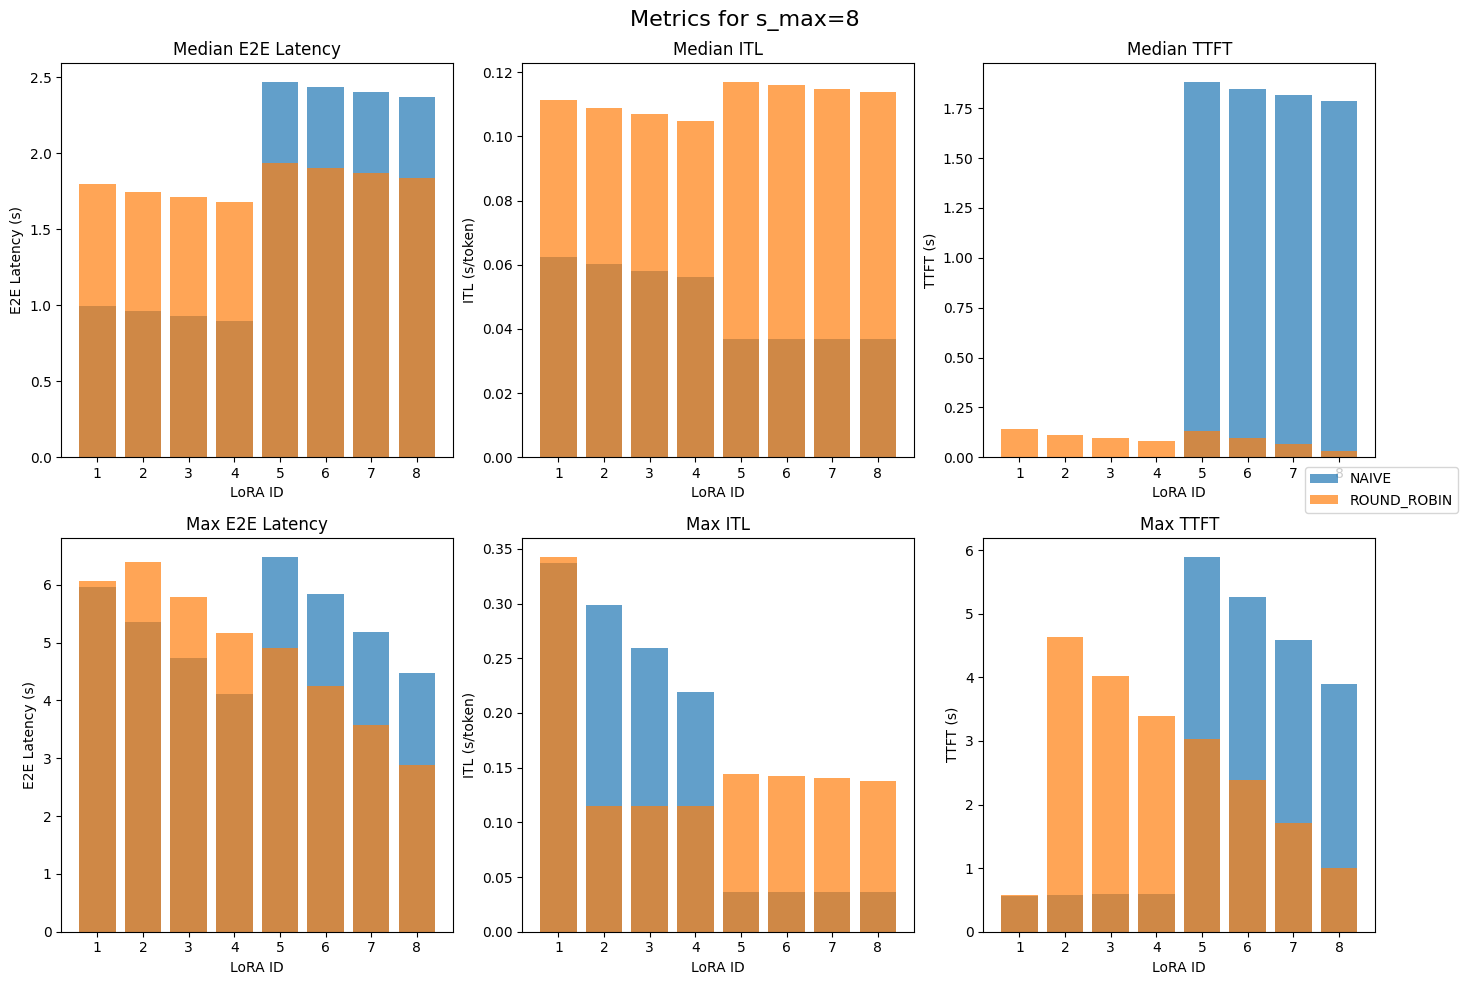

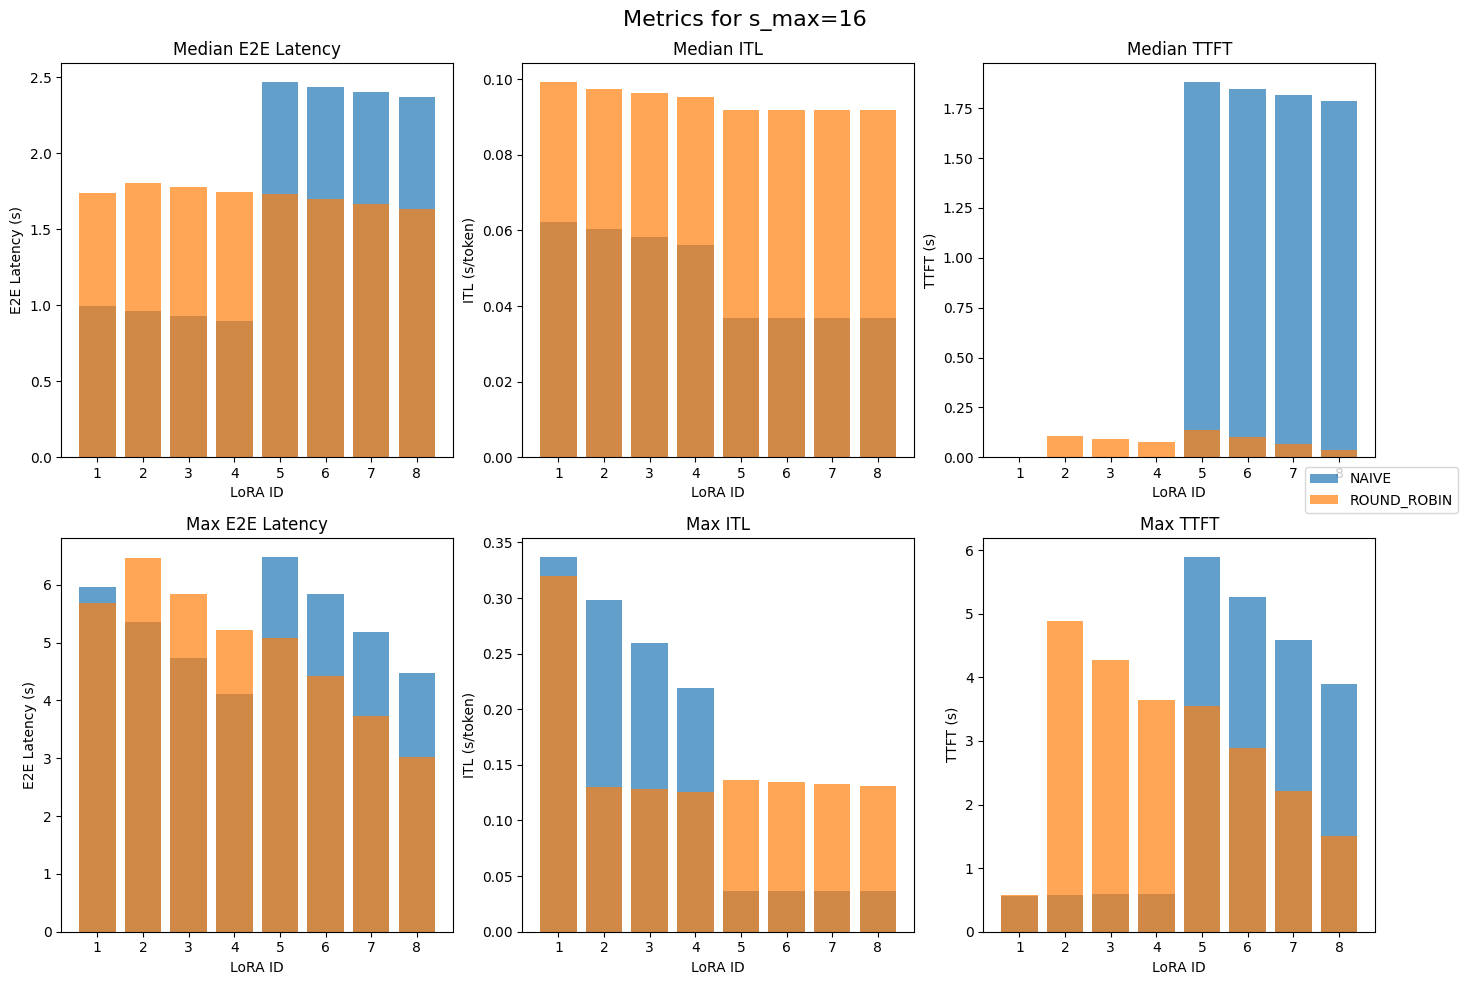

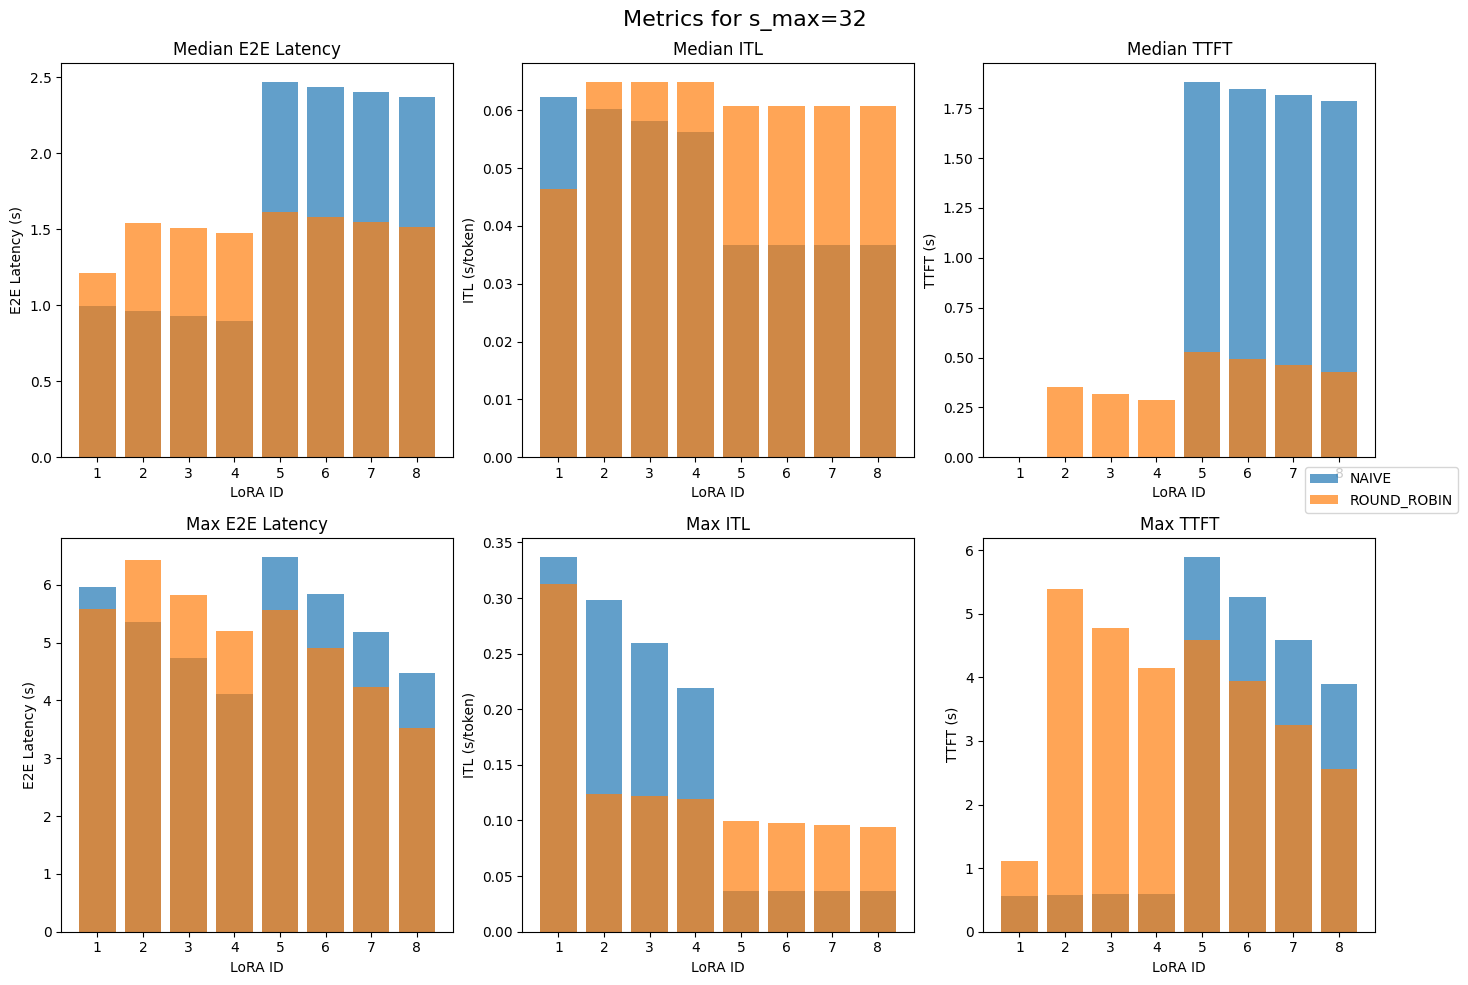

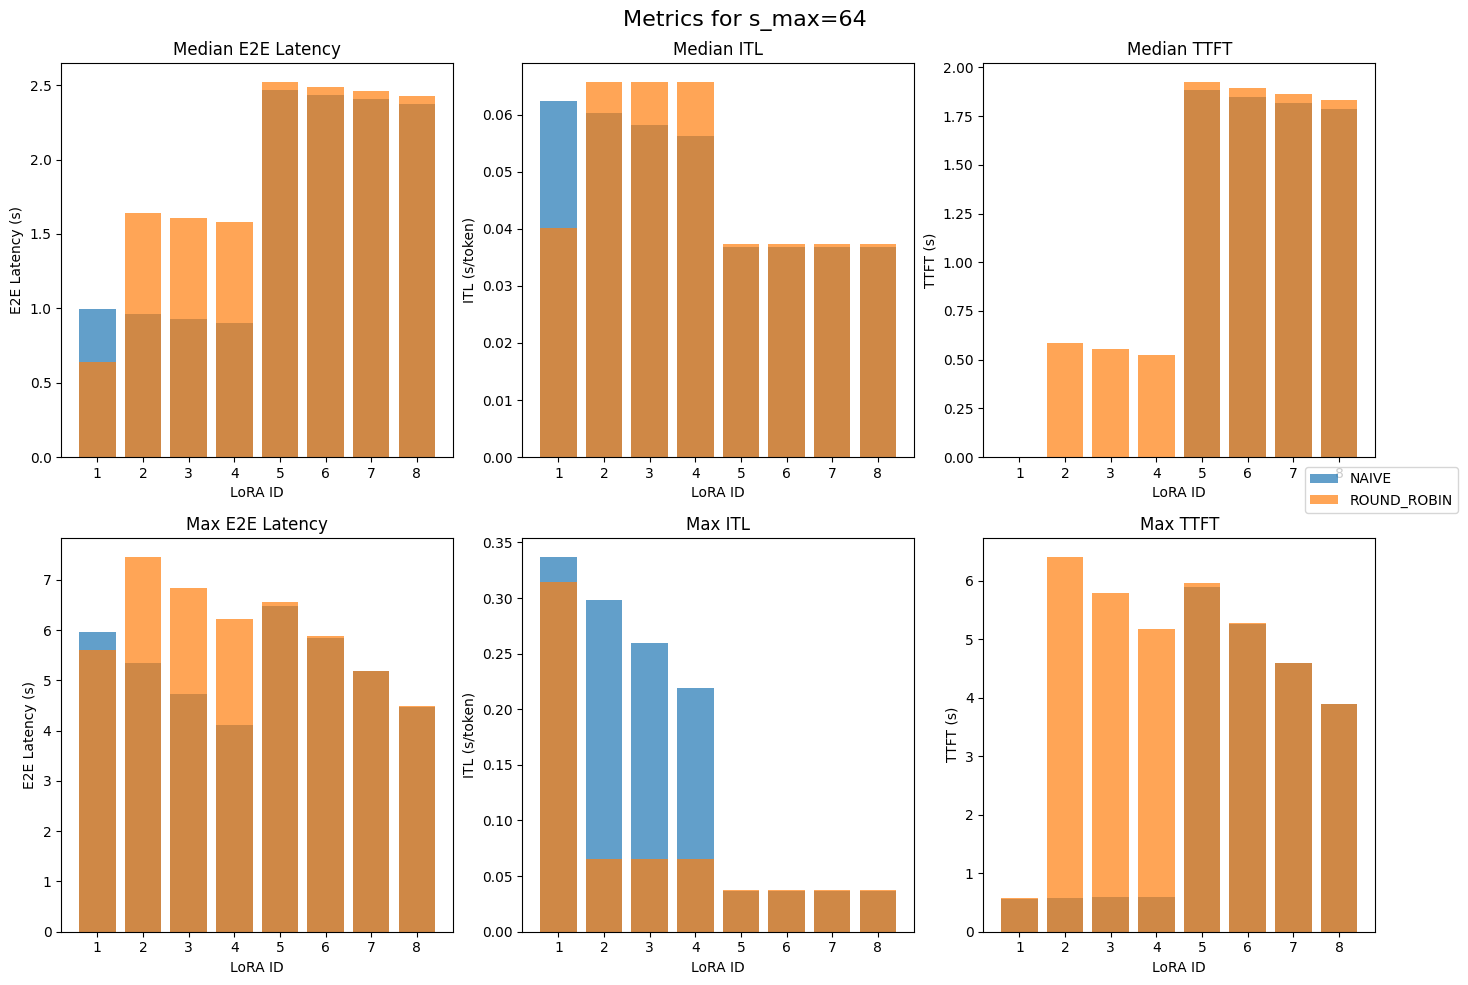

In [9]:
metrics_df = pd.read_csv("../out/metrics_new.csv")
plot_metrics(metrics_df)

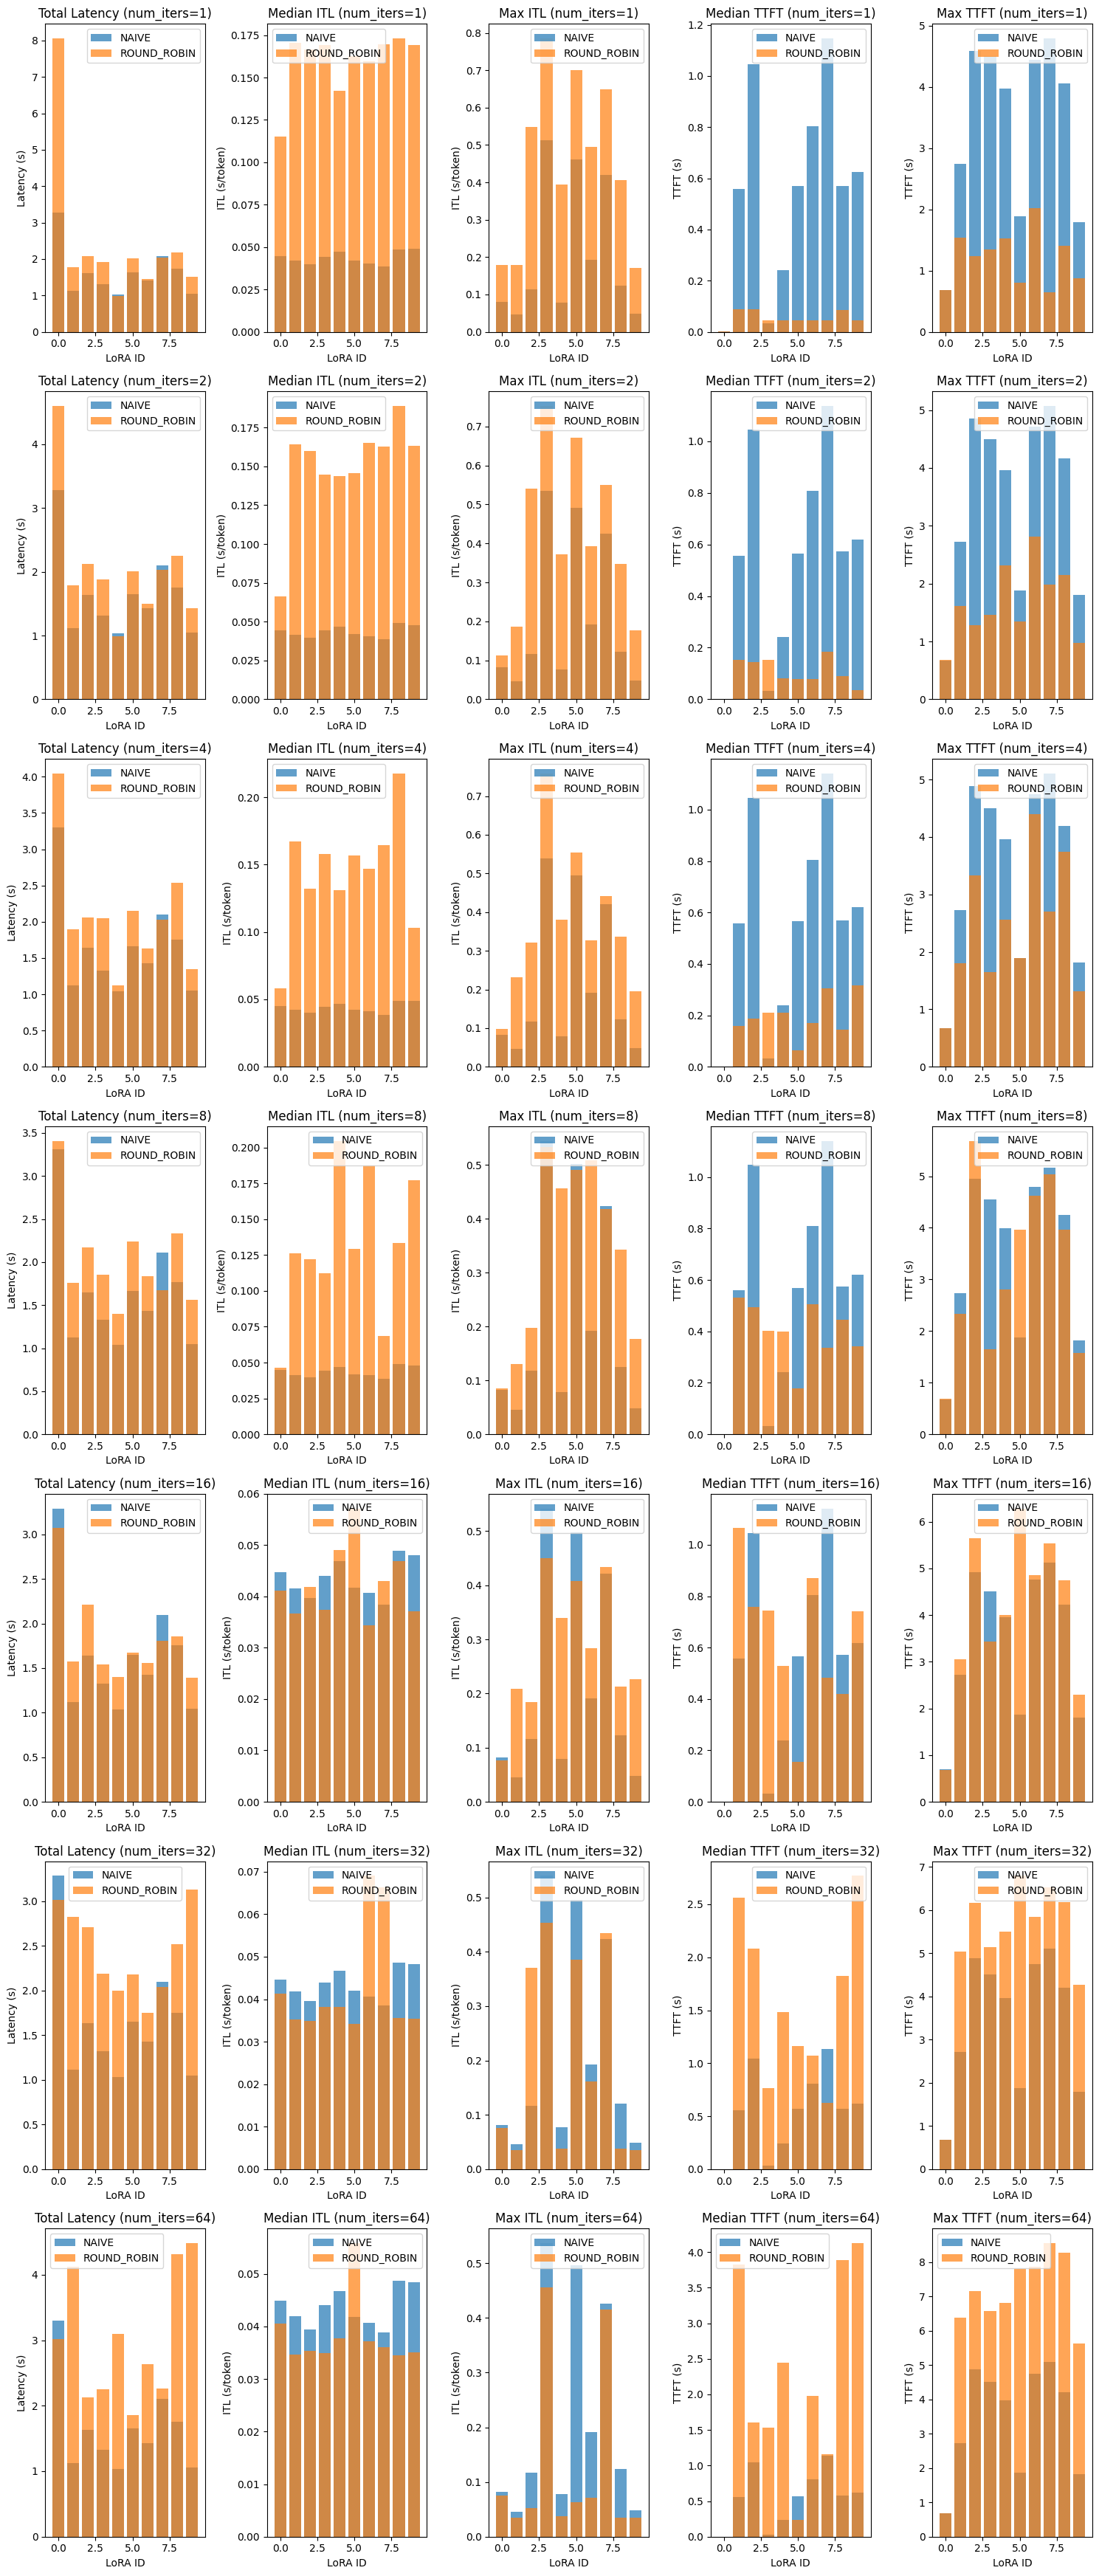

In [18]:
metrics_df = pd.read_csv("../out/metrics_short.csv")
plot_metrics(metrics_df)

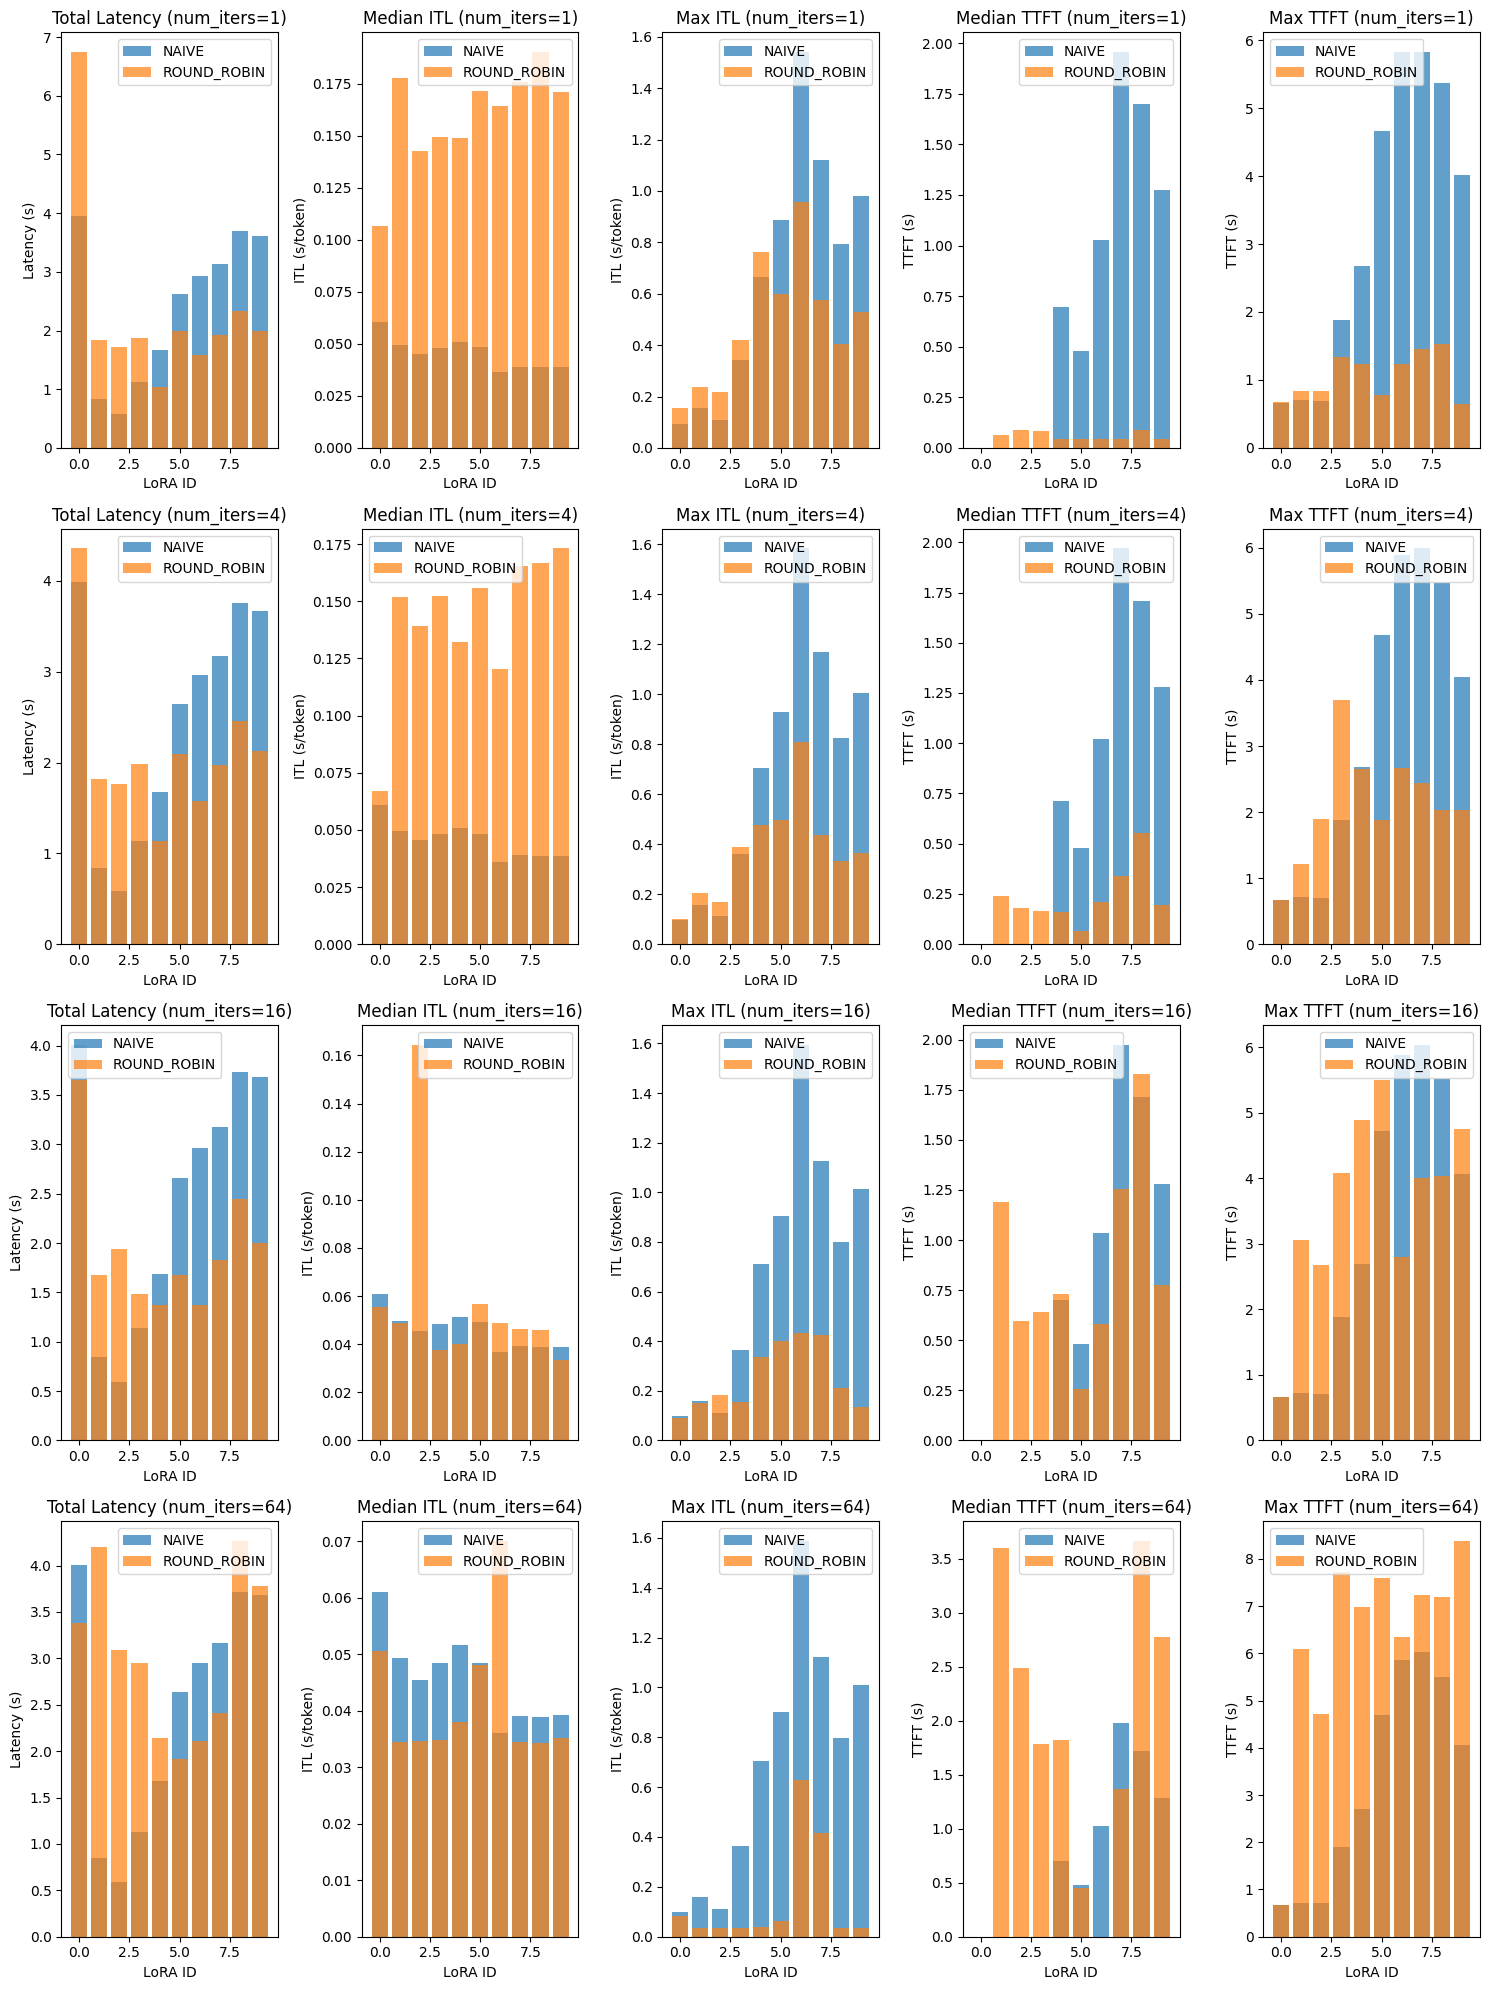

In [10]:
metrics_df = pd.read_csv("../out/metrics_naive_fix.csv")
plot_metrics(metrics_df)

In [18]:
def plot_metrics(metrics_df):
    # Recompute metrics based on the clarified definitions
    metrics_df['itl'] = (metrics_df['last_token_time'] - metrics_df['first_scheduled_time']) / metrics_df['output_num_tokens']
    metrics_df['ttft'] = metrics_df['first_scheduled_time'] - metrics_df['arrival_time']
    metrics_df['total_latency'] = metrics_df['finished_time'] - metrics_df['arrival_time']

    # Group by LoRA policy, LoRA ID, num_iters_before_lora_reschedule, and max_loras
    revised_grouped = metrics_df.groupby(
        ['lora_policy', 'lora_id', 'num_iters_before_lora_reschedule', 'max_loras']
    ).agg({
        'total_latency': ['mean', 'std'],
        'itl': ['mean', 'std'],
        'ttft': ['mean', 'std']
    }).reset_index()

    # Simplify column names
    revised_grouped.columns = [
        'lora_policy', 'lora_id', 'num_iters_before_lora_reschedule', 'max_loras',
        'latency_mean', 'latency_std',
        'itl_mean', 'itl_std',
        'ttft_mean', 'ttft_std'
    ]

    # Unique combinations of num_iters_before_lora_reschedule and max_loras
    unique_iters = revised_grouped['num_iters_before_lora_reschedule'].unique()
    unique_max_loras = revised_grouped['max_loras'].unique()

    for max_loras in sorted(unique_max_loras):
        # Filter by max_loras
        max_loras_subset = revised_grouped[revised_grouped['max_loras'] == max_loras]

        fig, axs = plt.subplots(len(unique_iters), 3, figsize=(15, 5 * len(unique_iters)))
        fig.suptitle(f"Metrics for max_loras={max_loras}", fontsize=16)

        for idx, num_iters in enumerate(sorted(unique_iters)):
            # Filter by num_iters_before_lora_reschedule
            subset = max_loras_subset[max_loras_subset['num_iters_before_lora_reschedule'] == num_iters]
            naive_data = subset[subset['lora_policy'] == 'LoraPolicy.NAIVE']
            rr_data = subset[subset['lora_policy'] == 'LoraPolicy.ROUND_ROBIN']

            # Total Latency
            axs[idx, 0].bar(naive_data['lora_id'], naive_data['latency_mean'], label='NAIVE', alpha=0.7)
            axs[idx, 0].bar(rr_data['lora_id'], rr_data['latency_mean'], label='ROUND_ROBIN', alpha=0.7)
            axs[idx, 0].set_title(f"Total Latency (num_iters={num_iters})")
            axs[idx, 0].set_xlabel("LoRA ID")
            axs[idx, 0].set_ylabel("Latency (s)")
            axs[idx, 0].legend()

            # ITL (Inter-Token Latency)
            axs[idx, 1].bar(naive_data['lora_id'], naive_data['itl_mean'], label='NAIVE', alpha=0.7)
            axs[idx, 1].bar(rr_data['lora_id'], rr_data['itl_mean'], label='ROUND_ROBIN', alpha=0.7)
            axs[idx, 1].set_title(f"ITL (Inter-Token Latency, num_iters={num_iters})")
            axs[idx, 1].set_xlabel("LoRA ID")
            axs[idx, 1].set_ylabel("ITL (s/token)")
            axs[idx, 1].legend()

            # TTFT (Time to First Token)
            axs[idx, 2].bar(naive_data['lora_id'], naive_data['ttft_mean'], label='NAIVE', alpha=0.7)
            axs[idx, 2].bar(rr_data['lora_id'], rr_data['ttft_mean'], label='ROUND_ROBIN', alpha=0.7)
            axs[idx, 2].set_title(f"TTFT (Time to First Token, num_iters={num_iters})")
            axs[idx, 2].set_xlabel("LoRA ID")
            axs[idx, 2].set_ylabel("TTFT (s)")
            axs[idx, 2].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

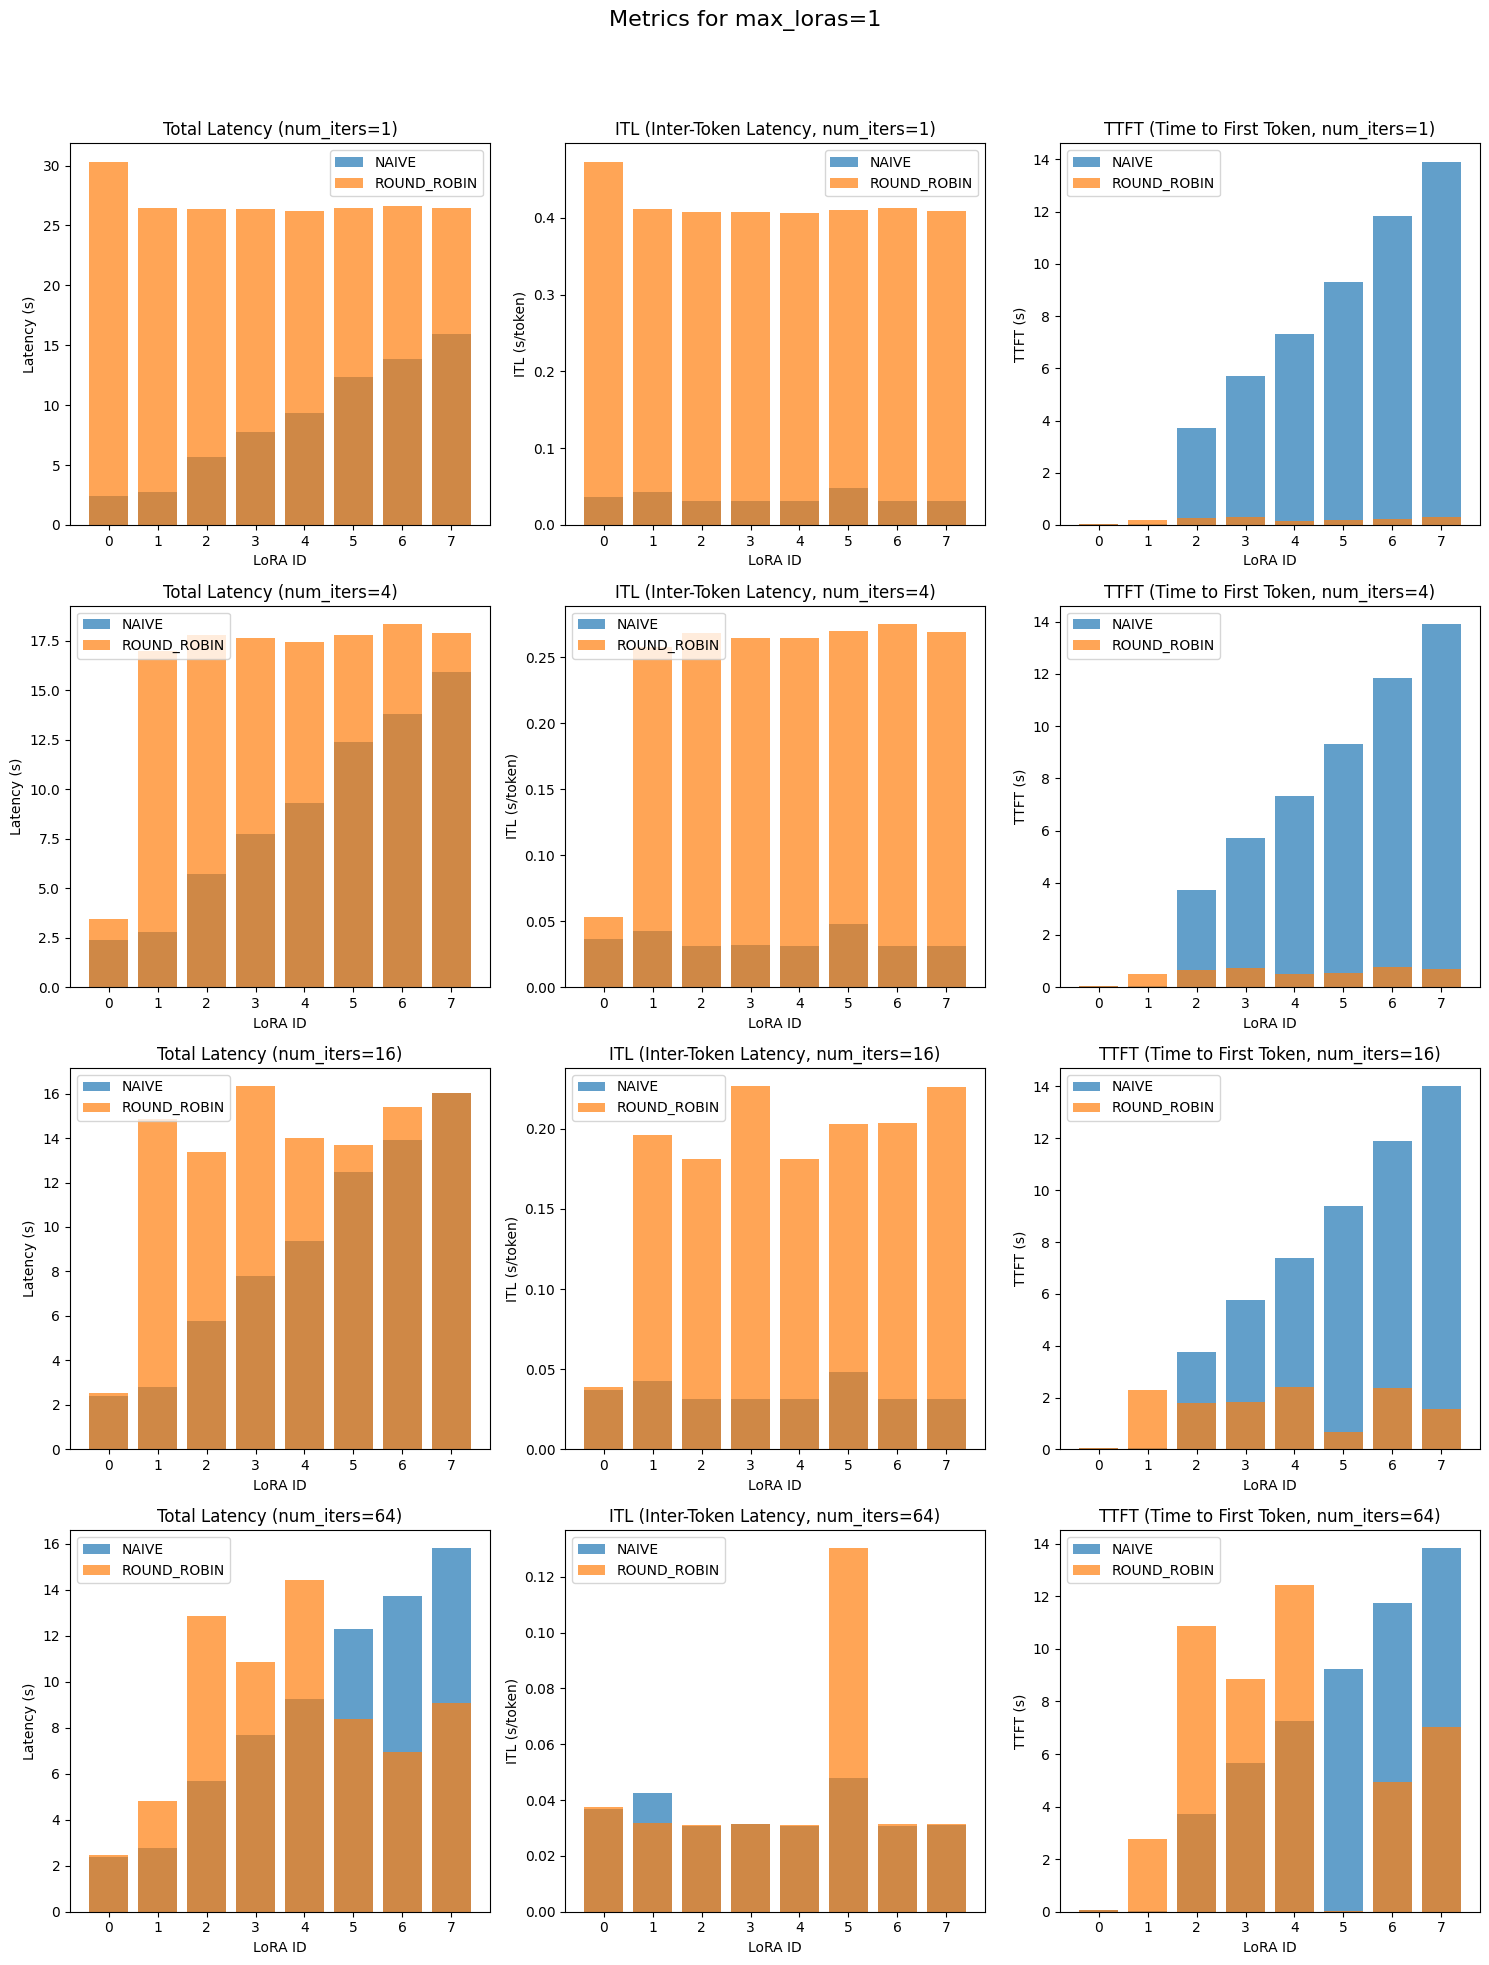

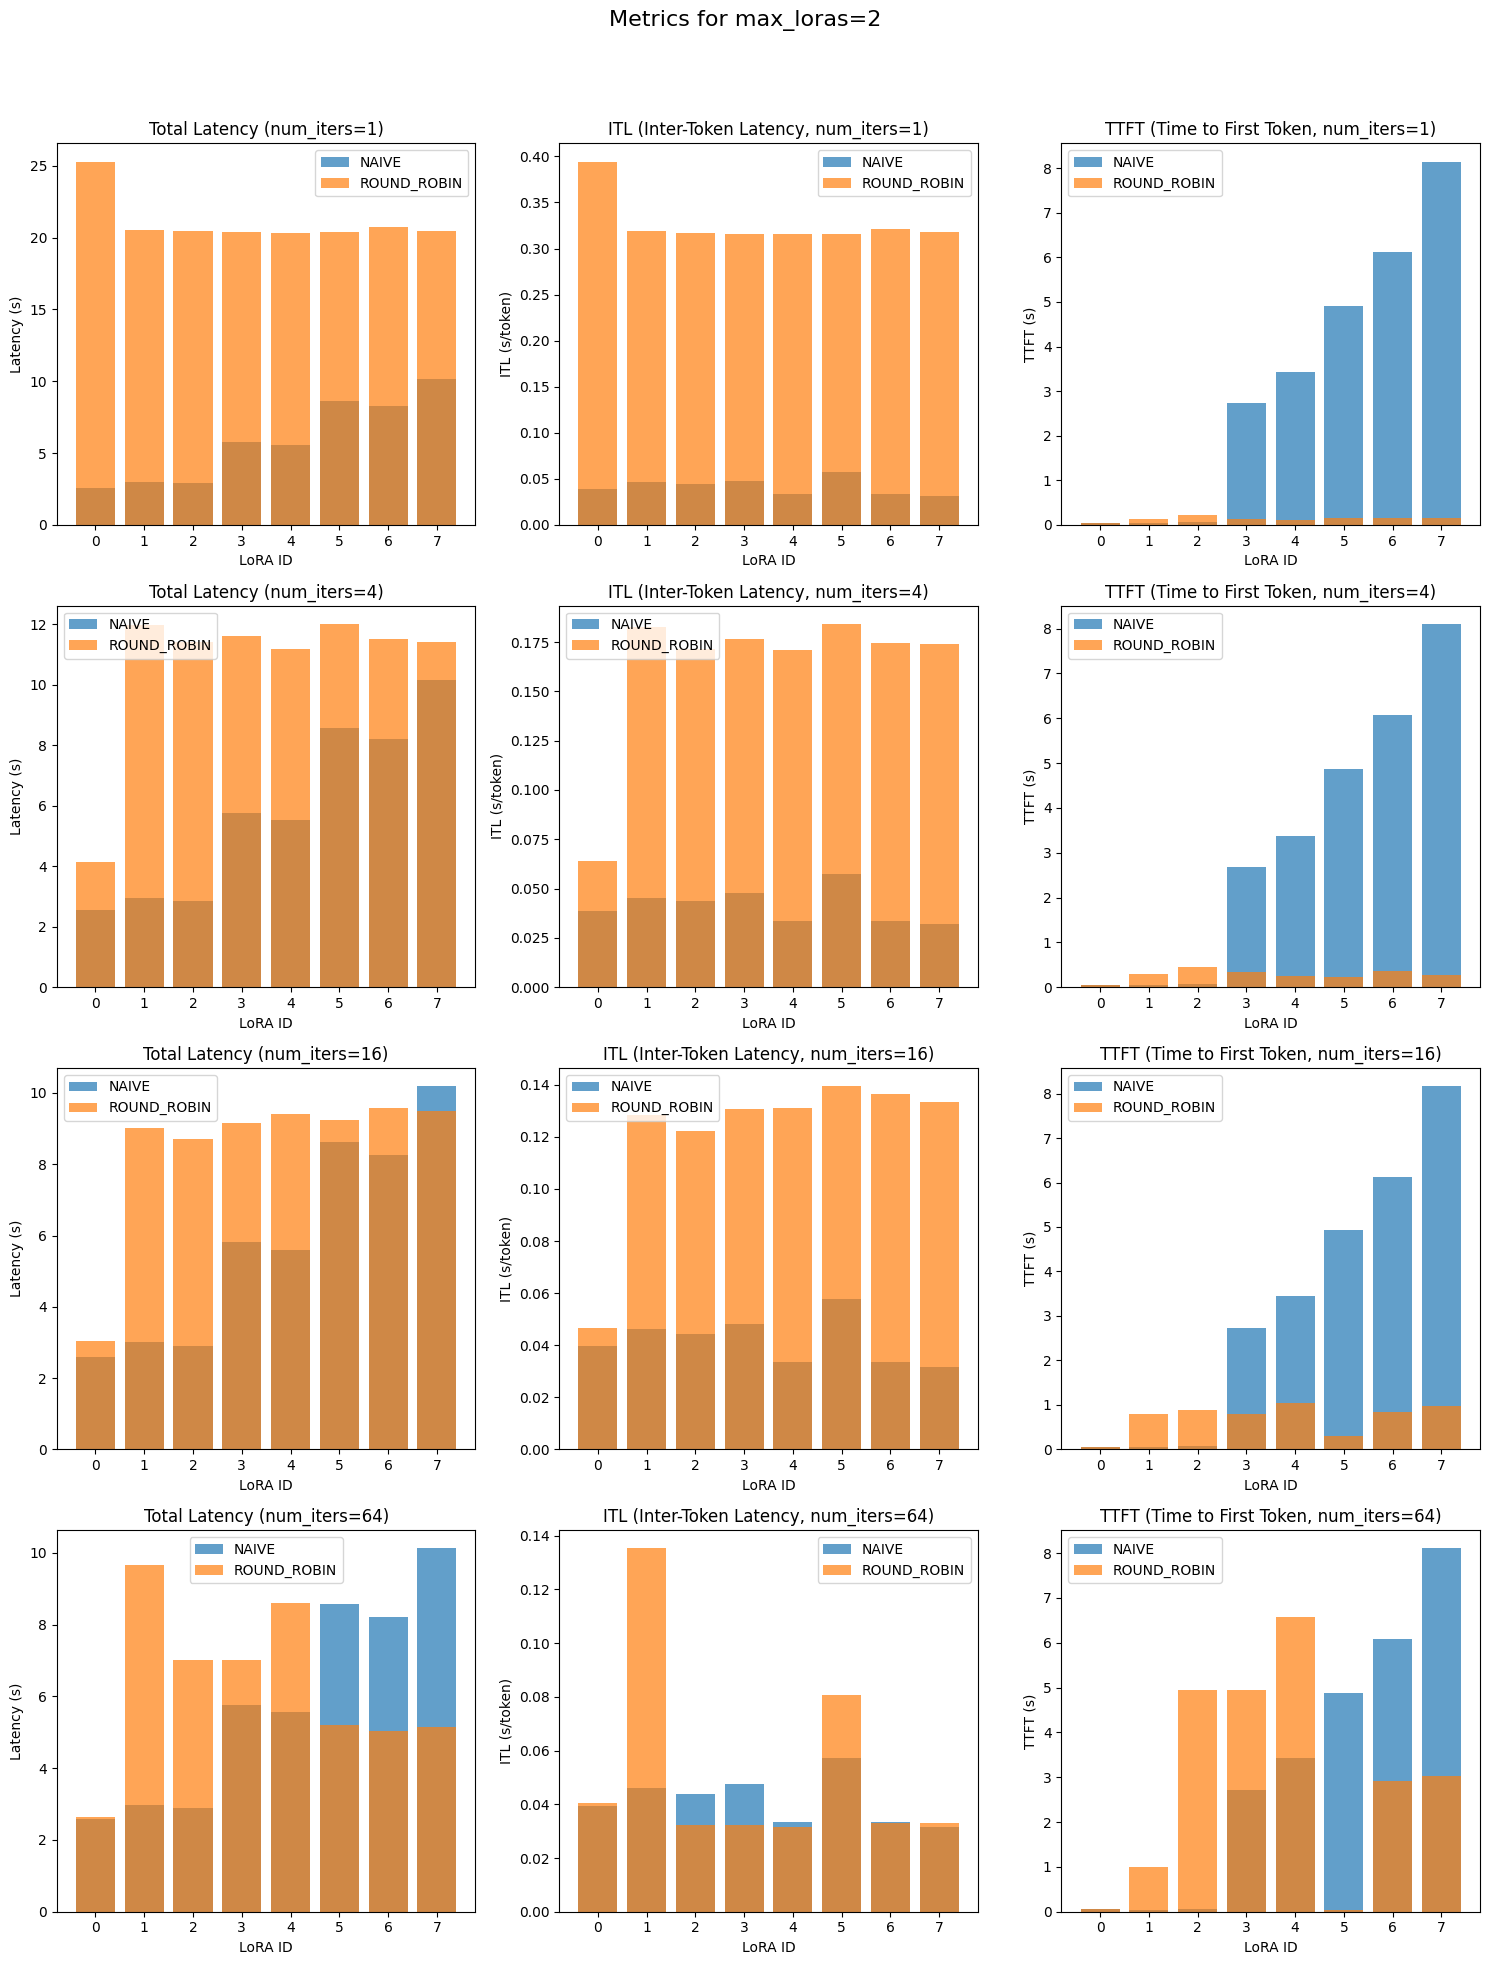

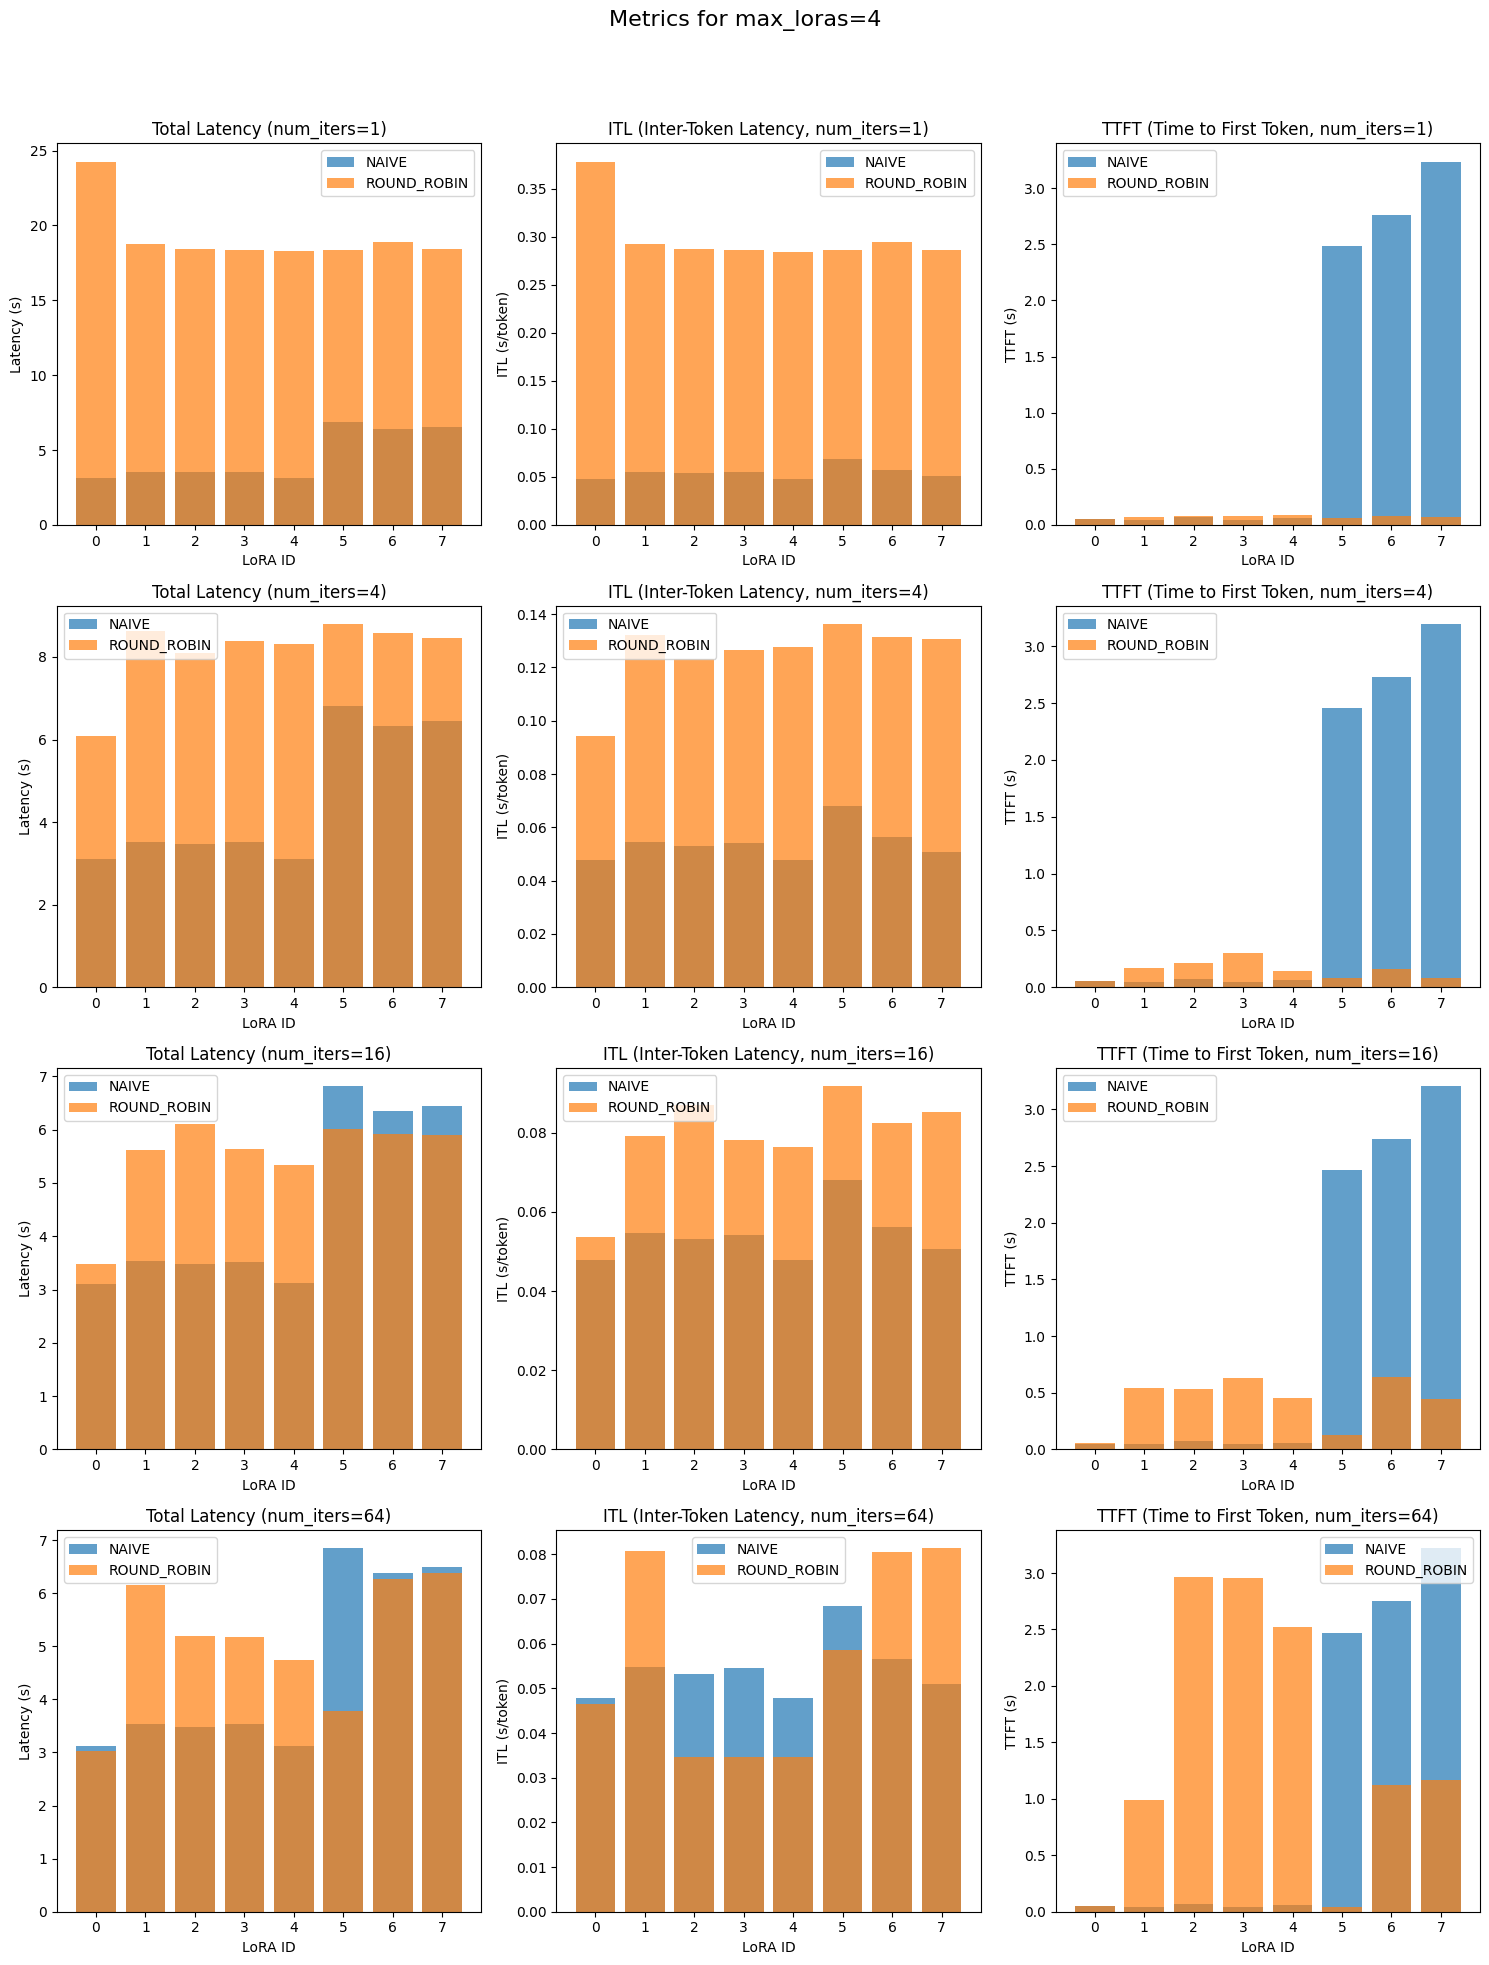

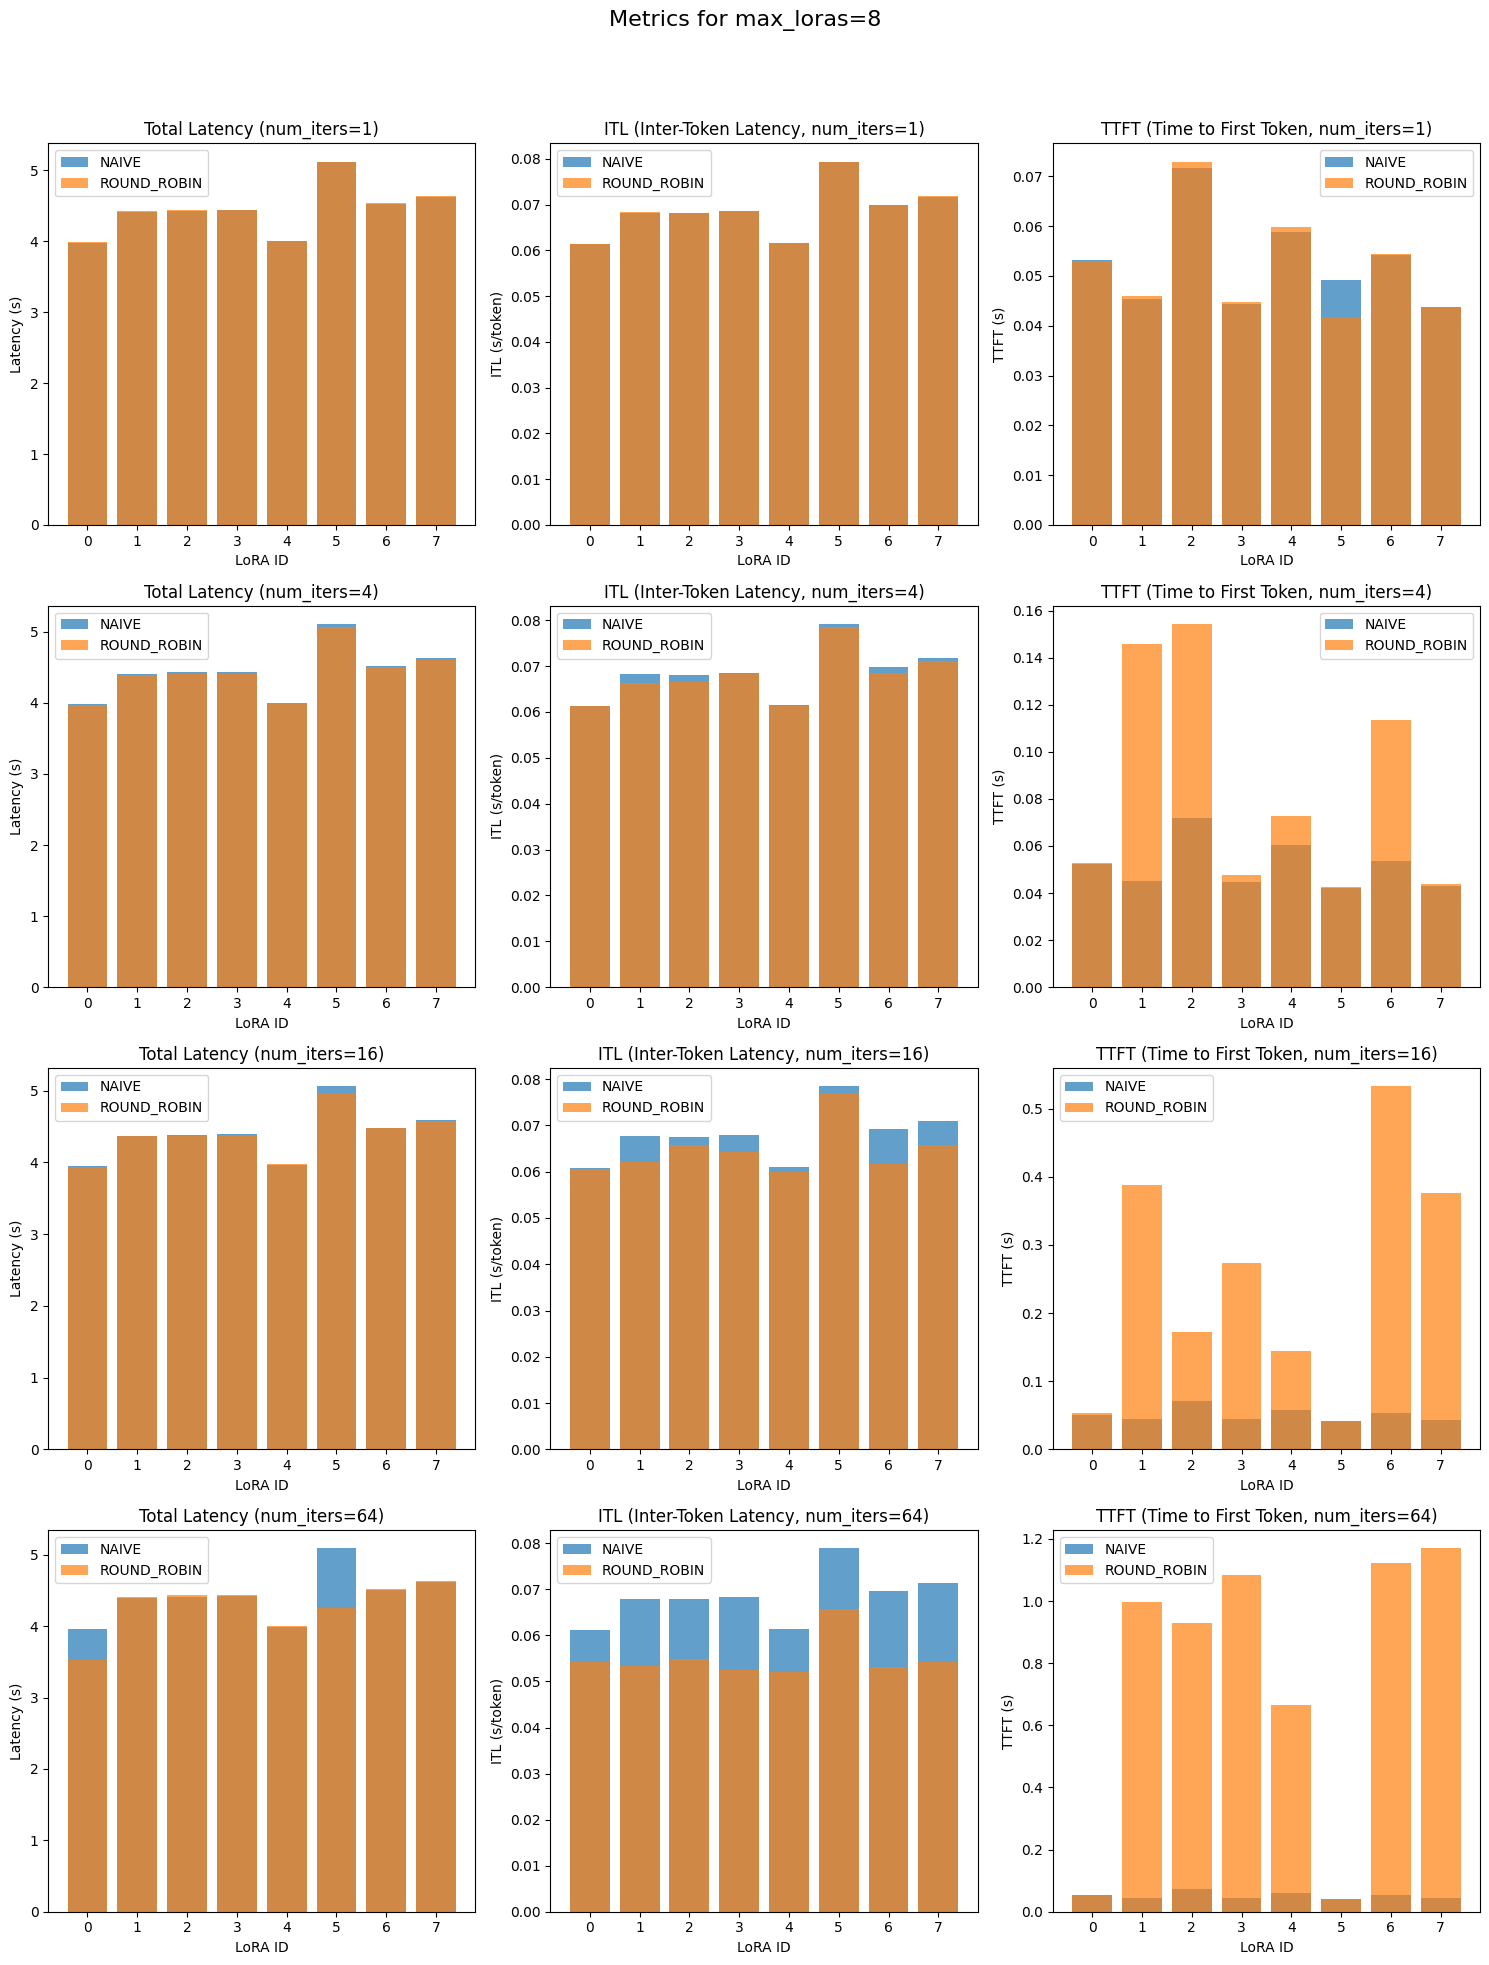

In [20]:
metrics_df = pd.read_csv("../out/metrics_max_loras.csv")
plot_metrics(metrics_df)